In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re

from matplotlib import pyplot as plt

%matplotlib inline

#Helpers
def downcast(df, from_type, to_type):
    orig_columns = df.columns
    df_match = df.select_dtypes(include=[from_type])
    converted_df = df_match.apply(pd.to_numeric,downcast=to_type)
    res = df.drop(df_match.columns, axis = 1, inplace=False)
    return res.join(converted_df)[orig_columns]

In [2]:
categories = pd.read_csv("data/item_categories.csv", dtype={'item_category_name': 'str', 'item_category_id': 'int8'})
items = pd.read_csv("data/items.csv", dtype={'item_name': 'str', 'item_id': 'int16', 'item_category_id': 'int8'})
shops = pd.read_csv("data/shops.csv", dtype={'shop_name': 'str', 'shop_id': 'int8'})
sales = pd.read_csv("data/sales_train_v2.csv",dtype={'date_block_num': 'int8', 'shop_id': 'int8', 'item_id': 'int16', 
                          'item_price': 'float16', 'item_cnt_day': 'float16'})
sample = pd.read_csv("data/sample_submission.csv", dtype={'ID': 'int32', 'item_cnt_month': 'float16'})
test = pd.read_csv("data/test.csv", dtype={'ID': 'int32', 'shop_id': 'int8', 'item_id': 'int16'})

In [3]:
category_types = categories.item_category_name.str.split(' ').apply(lambda x: x[0]).str.replace('[\W]', '').str.strip()
categories['category_type'] = pd.Categorical(category_types).codes

city = shops.shop_name.str.split().apply(lambda x: x[0]).str.replace('[\W\d²]', ' ').str.strip()
shops['city'] = pd.Categorical(city).codes

In [4]:
categories.drop(['item_category_name'], axis=1, inplace=True)
shops.drop(['shop_name'], axis=1, inplace=True)
items.drop(['item_name'], axis=1, inplace=True)

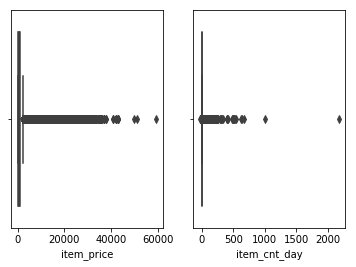

In [5]:
# show outliers
fig, ax = plt.subplots(1,2)
sns.boxplot(sales['item_price'], ax=ax[0])
sns.boxplot(sales['item_cnt_day'], ax=ax[1])

In [6]:
# show lowest prices
sales.item_price.sort_values().head()
sales.item_price.sort_values(ascending=False).head()

1163158             inf
885138     5.920000e+04
1488135    5.100800e+04
2327159    4.979200e+04
2910156    4.297600e+04
Name: item_price, dtype: float16

In [7]:
# drop outliers
sales = sales[(sales.item_price > 0) & (sales.item_price < 100000) & (sales.item_cnt_day < 1500)]

# take only data that is relavent to the test set
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()

sales = sales[sales.shop_id.isin(test_shops)]
sales = sales[sales.item_id.isin(test_items)]

In [8]:
# drop date - it's a mess
sales.drop('date', axis = 1, inplace=True)

# used in v1
sales['revenue'] = sales['item_cnt_day'] * sales['item_price'].astype('float32')

In [9]:
sales_g = sales.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False).agg(
    {
        'item_cnt_day': ['sum'], 
        'item_price': ['mean'],
        'revenue': ['sum']
    }
)

sales_g.columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'avg_item_price', 'revenue']
# clip data into 0,20 range
sales_g['item_cnt_month'] = sales_g.item_cnt_month.clip(0, 20)
sales_g = downcast(sales_g, 'int64', 'integer')

In [10]:
sales_empty = pd.DataFrame.from_records(itertools.product(test_shops, test_items, sales_g.date_block_num.unique()),
                                        columns = ['shop_id', 'item_id', 'date_block_num'])

In [11]:
# merge actual data with empty data to get the full dataset
sales_full = sales_g.merge(sales_empty, how='outer').sort_values('date_block_num')
# get month
sales_full['month'] = sales_full.date_block_num % 12
# get year
sales_full['year'] = sales_full.date_block_num // 12

sales_full.sort_values(['shop_id', 'item_id', 'date_block_num'], inplace=True)
sales_full.reset_index(drop=True, inplace=True)
sales_full = downcast(sales_full, 'int64', 'integer')

In [12]:
# join items, categories and shops
sales_full = sales_full \
.join(shops, on='shop_id', rsuffix='_REM') \
.join(items, on='item_id', rsuffix='_REM') \
.join(categories, on='item_category_id', rsuffix='_REM')

sales_full.drop(list(sales_full.filter(regex='_REM')), axis=1, inplace=True)

In [13]:
def get_shifted_value(data, columns, shift, column_names, grpby=['shop_id', 'item_id', 'date_block_num']):
    if type(columns) == str:
        columns = [columns]
    if type(column_names) == str:
        column_names = [column_names]
    t = data[grpby + columns]
    shifted = t.copy()
    shifted.columns = grpby + column_names
    shifted['date_block_num'] += shift
    df = pd.merge(data, shifted, on=grpby, how='left')
    return df

In [14]:
sales_full = get_shifted_value(sales_full, 'item_cnt_month', -1, 'predict_item_cnt_month')

prev = [1, 2, 3, 4, 6, 12]
for p in prev:
    sales_full = get_shifted_value(sales_full, 'item_cnt_month', p, 'prev%s_item_cnt_month' % p)
    
prev = [1, 2, 3, 4, 6, 12]
for p in prev:
    sales_full = get_shifted_value(sales_full, 'avg_item_price', p, 'prev%s_avg_item_price' % p)

prev = [1, 2, 3, 4, 6, 12]
for p in prev:
    sales_full = get_shifted_value(sales_full, 'revenue', p, 'prev%s_revenue' % p)

In [15]:
# min max price of an item
g = sales_full.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'avg_item_price':['min', 'max']})
g.columns = ['item_id', 'min_item_price', 'max_item_price']
sales_full = sales_full.merge(g, on='item_id', how='left')

# min max price of an item in that shop
g = sales_full.sort_values('date_block_num').groupby(['shop_id', 'item_id'], as_index=False).agg({'avg_item_price':['min', 'max']})
g.columns = ['shop_id', 'item_id', 'min_shop_item_price', 'max_shop_item_price']
sales_full = sales_full.merge(g, on=['shop_id','item_id'], how='left')

# diff between this price and global prices
sales_full['price_over_min_global'] = sales_full['avg_item_price'] - sales_full['min_item_price']
sales_full['price_below_max_global'] = sales_full['avg_item_price'] - sales_full['max_item_price']
# diff between this price and shop prices
sales_full['price_over_min_shop'] = sales_full['avg_item_price'] - sales_full['min_shop_item_price']
sales_full['price_below_max_shop'] = sales_full['avg_item_price'] - sales_full['max_shop_item_price']
# diff between shop price and global prices
sales_full['shop_min_price_over_min_global'] = sales_full['min_shop_item_price'] - sales_full['min_item_price']
sales_full['shop_max_price_below_max_global'] = sales_full['max_shop_item_price'] - sales_full['max_item_price']

# drop the initial min, max
sales_full.drop(['min_item_price', 'max_item_price', 'min_shop_item_price', 'max_shop_item_price'], axis=1, inplace=True)

In [16]:
def roll(window, stat):
    return lambda x: getattr(x.rolling(window=window, min_periods=1), stat)()

def add_rolled_values(data, column, windows, stats):
    for window, stat in itertools.product(windows, stats):
        res = '%s_w%s_%s' % (column, str(window), stat)
        print(res)
        data['%s_w%s_%s' % (column, str(window), stat)] = data.sort_values('date_block_num').\
                                                                groupby(['shop_id', 'item_id'])[column].\
                                                                apply(roll(window, stat))

In [17]:
add_rolled_values(sales_full, 'item_cnt_month', [2, 3, 4, 6, 12], ['mean', 'std'])

item_cnt_month_w2_mean
item_cnt_month_w2_std
item_cnt_month_w3_mean
item_cnt_month_w3_std
item_cnt_month_w4_mean
item_cnt_month_w4_std
item_cnt_month_w6_mean
item_cnt_month_w6_std
item_cnt_month_w12_mean
item_cnt_month_w12_std


In [18]:
def get_last_available_prev_column(data, regx):
    prog = re.compile(regx)
    columns = list(filter(lambda x: prog.match(x), data.columns))
    mask = data[columns].notnull().values
    return data[columns].values[np.arange(len(data)), np.argmin(mask, axis=1)]

sales_full['LA_item_cnt_month'] = get_last_available_prev_column(sales_full, 'prev\d_item_cnt_month')
sales_full['item_cnt_month_trend'] = sales_full['item_cnt_month'] - sales_full['LA_item_cnt_month']

sales_full['LA_avg_item_price'] = get_last_available_prev_column(sales_full, 'prev\d_avg_item_price')
sales_full['avg_item_price_trend'] = sales_full['avg_item_price'] - sales_full['LA_avg_item_price']

In [19]:
sales_full.to_pickle('sales_full_enh.pkl')